In [56]:
# Data import and cleaning.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Just a maybe-useful but messy function for seeing what's going on in the data table:
def describe_data(data):
    for col in data.columns:
        valc=data[col].value_counts()
        print('--------------')
        print('* ',col,len(valc),'values.')
        if len(valc)<10:
            print(valc)
        print(data[col].isnull().sum(),'NaNs')

# Performs one-hot encoding on all non-numerical variables and also drops rows containing missing data:
def one_hot(data):
    bad_columns=[]
    for col in data.columns:
        if data[col].dtype=='object':
            bad_columns.append(col)
    return pd.get_dummies(data.dropna(),columns=bad_columns,drop_first=False)
    
def downsample(data,var_to_balance):
    vc=data[var_to_balance].value_counts()
    imin=vc.idxmin()
    result=data[data[var_to_balance]==imin]
    for i in vc.index:
        if i!=imin:
            result=pd.concat([result,data[data[var_to_balance]==i].sample(vc[imin])])
    return result
    
raw_data=pd.read_csv("anemia_neater.csv")

# Replace mother's age group with the lowest boundary of respective age group (a useful numerical value):
clean_data=raw_data.assign(mothers_age_group = raw_data['mothers_age_group'].str[:2].astype(int),
                          child_tested = 1 - raw_data['childs_hemoglobin'].isna())

# Binarise the anemia dignosis columns
clean_data.replace({'Not anemic':0,'Mild':1,'Moderate':1,'Severe':1},inplace=True)

# A few "Don't know" values in the table; interpret as missing data:
clean_data.replace("Don't know",np.NaN,inplace=True)
# Yes/No to numbers; less one-hotting and clearer table:
clean_data.replace('Yes',1,inplace=True)
clean_data.replace('No',0,inplace=True)
#describe_data(clean_data)

# Just tables for subsequent analyses:
#testing_data=downsample(one_hot(clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_hemoglobin','childs_anemia'])),'child_tested')
testing_data=one_hot(clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_hemoglobin','childs_anemia']))
anemia_data=downsample(one_hot(clean_data.drop(columns=['mothers_hemoglobin','childs_hemoglobin','child_tested'])),'childs_anemia')
regression_data=one_hot(clean_data.drop(columns=['mothers_anemia','mothers_hemoglobin','childs_anemia','child_tested']))

print(anemia_data.shape)

(5940, 24)


* Without mothers' blood data: *
Cross validated F-scores:
random forest: F = 0.588
gradient boosted: F = 0.618
logistic reg: F = 0.620
quadratic SVM: F = 0.629


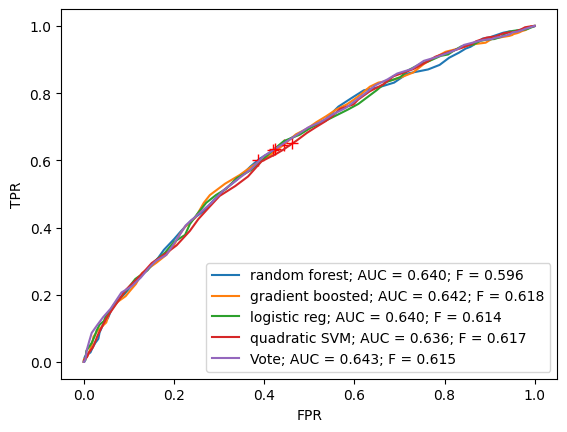

With mother' blood data
Cross validated F-scores:
random forest: F = 0.583
gradient boosted: F = 0.609
logistic reg: F = 0.616
quadratic SVM: F = 0.606


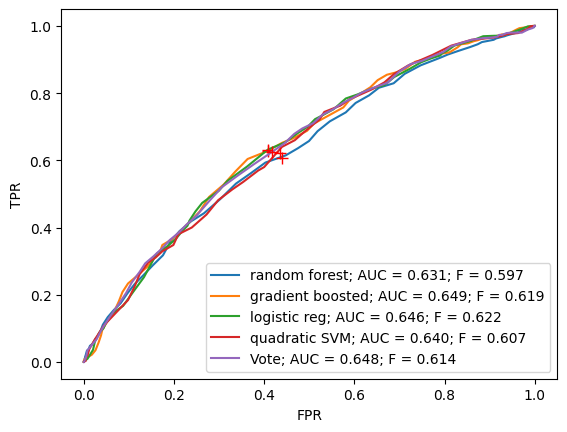

'\nprint("* Feature importances: *")\nfor f,i in zip(forestModel.feature_names_in_,forestModel.feature_importances_):\n    print(\'%s: %0.3f\' % (f,i))\n\nsubs_array=[]\nF1_array=[]\nsubs=0.05\nwhile subs<1:\n    subs_array.append(subs)\n    model=GradientBoostingClassifier(subsample=subs,max_depth=None)\n    F1=cross_val_score(model,X_train,y_train,scoring=\'f1\',cv=10).mean()\n    print(\'%0.3f: %0.3f\' % (subs,F1))\n    F1_array.append(F1)\n    subs+=0.1\nplt.plot(subs_array,F1_array)\nplt.xlabel(\'subsample\')\nplt.ylabel(\'GB F-score\')\nplt.show()\n'

In [67]:
# Classifiers.

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Returns a confusion matrix from given predicted probabilities vs actual labels and a threshold value.
def calculate_confusion(y_pred,y_test,threshold):
    df=pd.DataFrame({'p':y_pred, 'y':y_test.reset_index(drop=True)})
    df['predicted'] = (df['p']>=threshold)
    tots=len(df['predicted'])
    fp=(df['predicted']>df['y']).sum()
    fn=(df['predicted']<df['y']).sum()
    tp=df['predicted'].sum() - fp;
    tn = tots - fp - fn - tp;
    return ([[tp, fn], [fp, tn]])

# Just F-score from a model and test data:
def calculate_F (model,X_test,y_test):
    predictions=model.predict(X_test)
    TP=((predictions==1) & (y_test==1)).sum()
    FP=(predictions>y_test).sum()
    FN=(predictions<y_test).sum()
    return 2*TP/(2*TP+FP+FN)

# Calculates an approximate ROC curve for given classifier model, and returns its AUC. 
# If drawPicture=True (default) then also draws the curve, otherwise simply does the calculations for AUC.
# If showCutoff in given then draws a cross on the curve at that point.
# plt.show() is not called, so subsequent drawings go to the same picture (useful for comparing models).
def analyse_ROC(model,X_test,y_test,title='',steps=100,drawPicture=True,showCutoff=None):
    probabilities=pd.DataFrame(model.predict_proba(X_test))
    p=0
    dp=1/steps
    tpr_array=[]
    fpr_array=[]
    while p<=1:
        confusion=calculate_confusion(probabilities[1],y_test,p)
        tpr_array.append(confusion[0][0]/sum(confusion[0]))
        fpr_array.append(confusion[1][0]/sum(confusion[1]))
        p+=dp
    tpr_array.append(0)
    fpr_array.append(0)
    tpr_array=np.array(tpr_array)
    fpr_array=np.array(fpr_array)
    AUC=0
    for i in range(1,len(tpr_array)):
        AUC += (tpr_array[i-1]+tpr_array[i])/2 * (fpr_array[i-1]-fpr_array[i])
    
    if drawPicture:
        plt.plot(fpr_array,tpr_array,
                 label="{title}; AUC = {AUC:.3f}; F = {F:.3f}".format(title=title,AUC=AUC,F=calculate_F(model,X_test,y_test)))
        if not (showCutoff is None):
            confusion=calculate_confusion(probabilities[1],y_test,showCutoff)
            plt.plot(confusion[1][0]/sum(confusion[1]),confusion[0][0]/sum(confusion[0]),'r+',markersize=8)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return AUC

def compare_models(models,data,dep_column):
    X_train,X_test,y_train,y_test = train_test_split(anemia_data.drop(columns=dep_column),
                                                 anemia_data[dep_column],
                                                 test_size=0.25)
    print('Cross validated F-scores:')
    for pair in models:
        mud=pair[1].fit(X_train,y_train)
        analyse_ROC(mud,X_test,y_test,title=pair[0],showCutoff=0.5)
        F1=cross_val_score(pair[1],X_train,y_train,scoring='f1').mean()
        print("%s: F = %.3f" % (pair[0],F1))
    #mud=VotingClassifier(models,voting='soft').fit(X_train,y_train)
    #analyse_ROC(mud,X_test,y_test,title='Vote',showCutoff=0.5)
    plt.legend()
    plt.show()
    

#X_train,X_test,y_train,y_test = train_test_split(testing_data.drop(columns="child_tested"),
#                                                 testing_data["child_tested"],
#                                                 test_size=0.3)

X_train,X_test,y_train,y_test = train_test_split(anemia_data.drop(columns="childs_anemia"),
                                                 anemia_data["childs_anemia"],
                                                 test_size=0.3)

logReg=make_pipeline(StandardScaler(),LogisticRegression())
quadSVM=SVC(kernel='poly',degree=2,gamma='auto',probability=True)

classifiers = [
    ('random forest',RandomForestClassifier(n_estimators=100,max_samples=0.03,max_depth=None,n_jobs=6)),
    ('gradient boosted',GradientBoostingClassifier()),
    ('logistic reg',logReg), # LogisticRegression(max_iter=1000)),
    ('quadratic SVM',quadSVM),
    #('AdaBoost',AdaBoostClassifier(n_estimators=100)) # horrible
]

print("* Without mothers' blood data: *")
compare_models(classifiers,anemia_data.drop(columns=['mothers_anemia']),'childs_anemia')
print("With mother' blood data")
compare_models(classifiers,anemia_data,'childs_anemia')

'''
print("* Feature importances: *")
for f,i in zip(forestModel.feature_names_in_,forestModel.feature_importances_):
    print('%s: %0.3f' % (f,i))

subs_array=[]
F1_array=[]
subs=0.05
while subs<1:
    subs_array.append(subs)
    model=GradientBoostingClassifier(subsample=subs,max_depth=None)
    F1=cross_val_score(model,X_train,y_train,scoring='f1',cv=10).mean()
    print('%0.3f: %0.3f' % (subs,F1))
    F1_array.append(F1)
    subs+=0.1
plt.plot(subs_array,F1_array)
plt.xlabel('subsample')
plt.ylabel('GB F-score')
plt.show()
'''

Text(0, 0.5, 'Count')

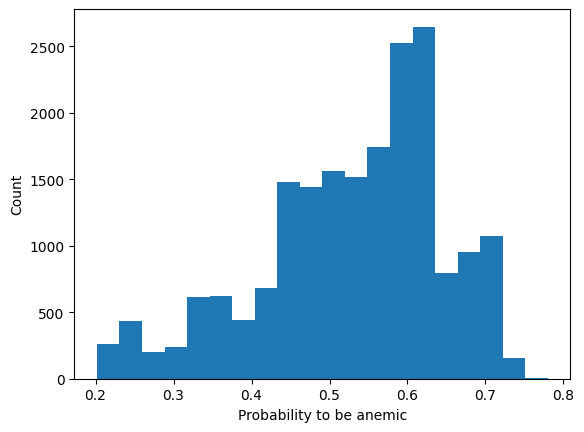

In [71]:
untested_data=testing_data[testing_data['child_tested']==0].drop(columns='child_tested')
untested_data.head()

model=logReg.fit(X_train.drop(columns='mothers_anemia'),y_train)
#model=quadSVM.fit(X_train.drop(columns='mothers_anemia'),y_train)
predictions2=pd.DataFrame(model.predict_proba(untested_data))
predictions2.columns=['Not','Anemic']
ax=predictions2['Anemic'].hist(bins=20,grid=False)
ax.set_xlabel('Probability to be anemic')
ax.set_ylabel('Count')

mothers_age_group: 0.0842
mothers_births_5y: -0.3193
mothers_age_at_1st_birth: 0.1476
mothers_residence_Urban: 0.8333
mothers_education_No education: -1.1615
mothers_education_Primary: -0.6023
mothers_education_Secondary: -0.0000
mothers_wealth_index_Poorer: -2.0917
mothers_wealth_index_Poorest: -4.2365
mothers_wealth_index_Richer: 0.0000
mothers_wealth_index_Richest: 3.4961
mosquito_net_Yes: -0.0000
mother_smokes_Yes: 0.0000
mothers_marital_Married: 0.0000
mothers_partner_Staying elsewhere: 0.0000
fever_last_2_weeks_Yes: -3.6668
iron_pills_Yes: -0.0000


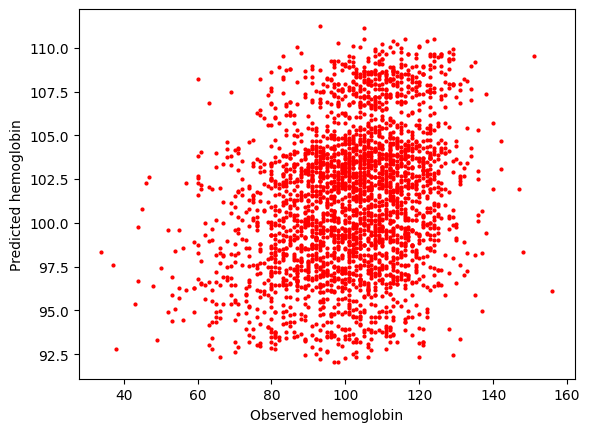

R2 = 0.073


In [19]:
# Regressions

from sklearn.linear_model import LinearRegression,Lasso,Ridge

# Just sum of squared deviations from mean for given array y
def SumSqr(y):
    y_mean=y.mean()
    return ((y-y_mean)**2).sum()

# Returns R-squared for given model - how much of the ebserved variance of y_obs it explains
def R2Model(model,X_obs,y_obs):
    return 1 - SumSqr(y_obs-model.predict(X_obs))/SumSqr(y_obs)

# Draws observed vs predicted scatterplot for given model; returns R2 as above
def ShowModel(model,X_obs,y_obs,obs_lab='Observed',pred_lab='Predicted'):
    y_pred=model.predict(X_obs)
    plt.plot(y_obs,y_pred,'ro',markersize=2)
    plt.xlabel(obs_lab)
    plt.ylabel(pred_lab)
    plt.show()
    return 1 - SumSqr(y_obs-y_pred)/SumSqr(y_obs)    

X_train, X_test, y_train, y_test = train_test_split(regression_data.drop(columns='childs_hemoglobin'),
                                                    regression_data['childs_hemoglobin'],test_size=0.3)

# Make some regression model and draw the resulting observed vs predicted relation:
model=Lasso(alpha=0.1).fit(X_train,y_train)
#model=LinearRegression().fit(X_train,y_train)

# Print out the model's corfs:
for i in range(0,len(model.coef_)):
    print('%s: %0.4f' % (model.feature_names_in_[i],model.coef_[i]))
    
# Show observed vs predicted graph and print R2:
print('R2 = %0.3f' % ShowModel(model,X_test,y_test,obs_lab="Observed hemoglobin",pred_lab="Predicted hemoglobin"))
